In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
pd.set_option('mode.chained_assignment',None)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='pandas')

In [2]:
df = pd.read_excel("Online Retail.xlsx",engine='openpyxl')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Data Inspection

In [3]:
# Get the shape of the dataset
num = df.shape
print("Number of rows:", num[0])
print("Number of columns:", num[1])
print("About the Book Dataframe: ")
df.describe()

Number of rows: 541909
Number of columns: 8
About the Book Dataframe: 


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [4]:
# Get the count of null values for each column
null_counts = df.isnull().sum()

# Filter out columns with null values
columns_with_null = null_counts[null_counts > 0]
print("Columns with null values:")
print(columns_with_null)

Columns with null values:
Description      1454
CustomerID     135080
dtype: int64


In [5]:
# To get the count of unique values for each column
unique_counts = df.nunique()

# For display columns with their corresponding unique value counts
print("Columns with unique values:")
print(unique_counts)

Columns with unique values:
InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64


### Data Cleaning

#### a.	Check for missing data and formulate apt strategy to treat them.

In [6]:
# Check for missing data
missing_data = df.isnull().sum()
missing_data

# Treat missing data (drop rows with missing values)
df = df.dropna()
# df.head()
df.shape

(406829, 8)

#### b.	Duplicates Check n Remove:

In [7]:
duplicate_rows = df.duplicated()

# Remove duplicates
df = df.drop_duplicates()
df.shape

(401604, 8)

#### c. Descriptive analytics:

In [8]:
# Descriptive analytics
descriptive_stats = df.describe(include = 'all', datetime_is_numeric=True)
descriptive_stats

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,401604.0,401604,401604,401604.000000,401604,401604.000000,401604.000000,401604
unique,22190.0,3684,3896,NaN,NaN,NaN,NaN,37
top,576339.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom
freq,542.0,2065,2058,NaN,NaN,NaN,NaN,356728
mean,NaN,NaN,NaN,12.183273,2011-07-10 12:08:23.848567552,3.474064,15281.160818,NaN
min,NaN,NaN,NaN,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000,NaN
25%,NaN,NaN,NaN,2.000000,2011-04-06 15:02:00,1.250000,13939.000000,NaN
50%,NaN,NaN,NaN,5.000000,2011-07-29 15:40:00,1.950000,15145.000000,NaN
75%,NaN,NaN,NaN,12.000000,2011-10-20 11:58:30,3.750000,16784.000000,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,NaN


### Cohort Analysis

In [9]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

#### a.	Create month cohorts and analyse active  customers for each cohort.

In [10]:
# Assuming 'InvoiceDate' is in datetime format
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# Function to extract the cohort month
def get_cohort_month(df):
    return df['InvoiceDate'].dt.to_period('M')

# Function to calculate the time offset in months
def get_month_offset(df):
    return (df['InvoiceDate'] - df['CohortMonth'].dt.start_time) / np.timedelta64(1, 'M')

In [11]:
# Assigning cohorts to each row
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Calculating the cohort index
df['CohortIndex'] = get_month_offset(df).astype(int) + 1

# Count the number of unique customers in each cohort
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()

# Pivot the data for better visualization
cohort_matrix = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_matrix

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,948.0,348.0,342.0,374.0,329.0,376.0,358.0,332.0,336.0,374.0,354.0,474.0,260.0
2011-01,404.0,124.0,116.0,100.0,139.0,126.0,111.0,105.0,130.0,146.0,158.0,51.0,NaN
2011-02,380.0,95.0,72.0,107.0,102.0,94.0,93.0,106.0,100.0,121.0,25.0,NaN,NaN
2011-03,425.0,99.0,108.0,96.0,98.0,78.0,118.0,99.0,128.0,47.0,NaN,NaN,NaN
2011-04,299.0,68.0,66.0,63.0,60.0,74.0,66.0,78.0,27.0,NaN,NaN,NaN,NaN
2011-05,271.0,74.0,47.0,47.0,59.0,69.0,71.0,33.0,NaN,NaN,NaN,NaN,NaN
2011-06,235.0,49.0,42.0,65.0,55.0,81.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,187.0,43.0,40.0,44.0,53.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,162.0,48.0,38.0,45.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### b. Also Analyse the retention rate of customers. Comment.

In [12]:
# Calculate the retention rate
cohort_size = cohort_matrix.iloc[:, 0]
retention_matrix = cohort_matrix.divide(cohort_size, axis=0)
retention_matrix

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.367089,0.360759,0.394515,0.347046,0.396624,0.377637,0.350211,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01,1.0,0.306931,0.287129,0.247525,0.344059,0.311881,0.274752,0.259901,0.321782,0.361386,0.391089,0.126238,NaN
2011-02,1.0,0.250000,0.189474,0.281579,0.268421,0.247368,0.244737,0.278947,0.263158,0.318421,0.065789,NaN,NaN
2011-03,1.0,0.232941,0.254118,0.225882,0.230588,0.183529,0.277647,0.232941,0.301176,0.110588,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.200669,0.247492,0.220736,0.260870,0.090301,NaN,NaN,NaN,NaN
2011-05,1.0,0.273063,0.173432,0.173432,0.217712,0.254613,0.261993,0.121771,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.208511,0.178723,0.276596,0.234043,0.344681,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.229947,0.213904,0.235294,0.283422,0.122995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.296296,0.234568,0.277778,0.141975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


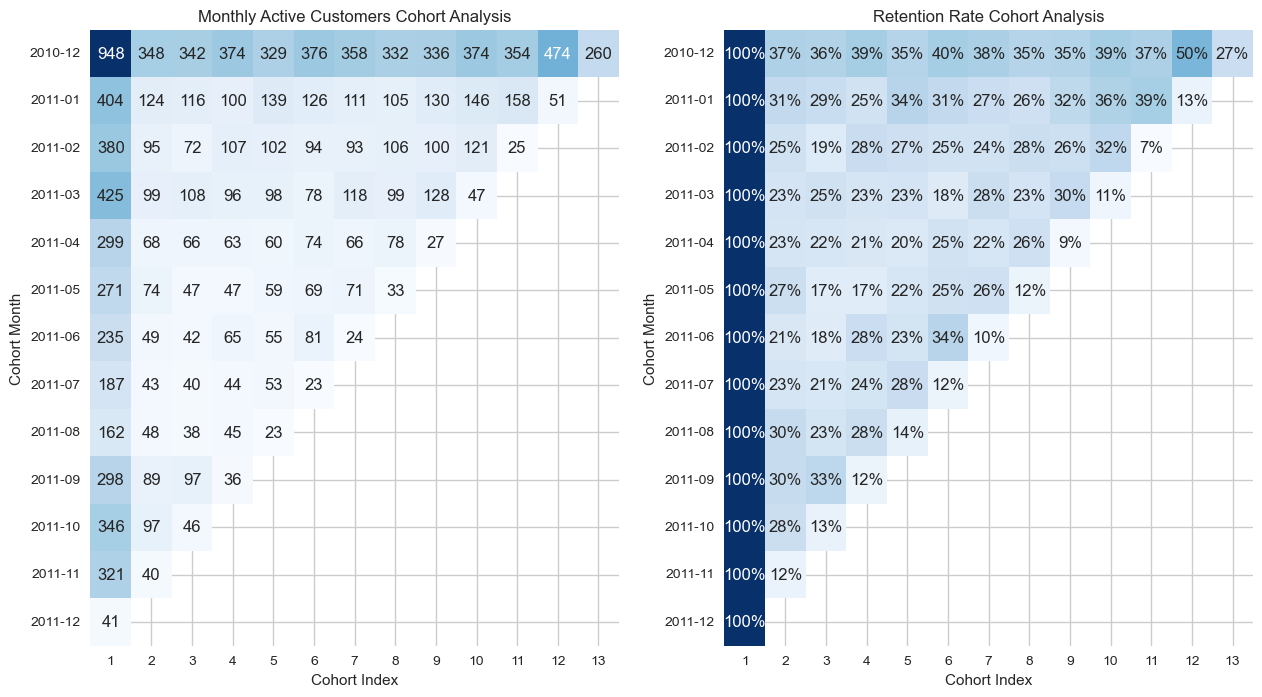

In [13]:
# Visualize the cohort matrix and retention rate
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
sns.heatmap(cohort_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Monthly Active Customers Cohort Analysis')
plt.xlabel('Cohort Index')
plt.ylabel('Cohort Month')

plt.subplot(1, 2, 2)
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='Blues', cbar=False)
plt.title('Retention Rate Cohort Analysis')
plt.xlabel('Cohort Index')
plt.ylabel('Cohort Month')

plt.show()

### RFM Analysis:

#### a. RFM Metrics:

In [14]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Recency, Frequency, and Monetary Calculation:
current_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,
    'InvoiceNo': 'count',
    'UnitPrice': 'sum'
})
rfm_df.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'UnitPrice': 'Monetary'}, inplace=True)
rfm_df

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,2.08
12347.0,2,182,481.21
12348.0,75,31,178.71
12349.0,19,73,605.10
12350.0,310,17,65.30
...,...,...,...
18280.0,278,10,47.65
18281.0,181,7,39.36
18282.0,8,13,62.68


#### b. Build RFM Segments:

In [15]:
# Function to assign R, F, and M scores
def assign_rfm_score(value, quantiles, reverse=False):
    if reverse:
        if value <= quantiles.iloc[0]:
            return 4
        elif value <= quantiles.iloc[1]:
            return 3
        elif value <= quantiles.iloc[2]:
            return 2
        else:
            return 1
    else:
        if value <= quantiles.iloc[0]:
            return 1
        elif value <= quantiles.iloc[1]:
            return 2
        elif value <= quantiles.iloc[2]:
            return 3
        else:
            return 4

# Calculate quantiles for Recency, Frequency, and Monetary
quantiles = rfm_df.quantile(q=[0.25, 0.5, 0.75])

# Assign R, F, and M scores
rfm_df['R'] = rfm_df['Recency'].apply(assign_rfm_score, args=(quantiles['Recency'], True))
rfm_df['F'] = rfm_df['Frequency'].apply(assign_rfm_score, args=(quantiles['Frequency'],))
rfm_df['M'] = rfm_df['Monetary'].apply(assign_rfm_score, args=(quantiles['Monetary'],))

# Create RFM segments and RFM score
rfm_df['RFM_Segment'] = rfm_df['R'].astype(str) + rfm_df['F'].astype(str) + rfm_df['M'].astype(str)
rfm_df['RFM_Score'] = rfm_df['R'] + rfm_df['F'] + rfm_df['M']

# Display the RFM segments
# print("\nRFM Segments:")
rfm_df[['Recency', 'Frequency', 'Monetary', 'RFM_Segment', 'RFM_Score']]

,Recency,Frequency,Monetary,RFM_Segment,RFM_Score
CustomerID,,,,,
12346.0,326,2,2.08,111,3
12347.0,2,182,481.21,444,12
12348.0,75,31,178.71,223,7
12349.0,19,73,605.10,334,10
12350.0,310,17,65.30,112,4
...,...,...,...,...,...
18280.0,278,10,47.65,111,3
18281.0,181,7,39.36,111,3
18282.0,8,13,62.68,412,7


#### c. Analyze the RFM Segments:

In [16]:
# Analyze RFM Segments
rfm_summary = rfm_df.groupby('RFM_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'RFM_Score': 'count'
}).sort_values('RFM_Score', ascending=False)

rfm_summary

,Recency,Frequency,Monetary,RFM_Score
RFM_Segment,,,,
444,6.855731,359.940711,1194.247530,506
111,262.178744,7.437198,22.768454,414
344,30.294776,226.384328,772.236978,268
211,86.117647,8.811765,23.513843,255
122,249.085837,26.330472,87.591502,233
222,84.627358,28.358491,85.397689,212
333,29.820755,68.900943,203.642217,212
233,83.024155,65.676329,199.746135,207
433,8.050000,68.405000,203.706450,200


### K Means:

#### a. Prepare the data for the algorithm:

In [17]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,2010-12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,2010-12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,1
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12,2011-08,5
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12,2011-08,5
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12,2011-08,5
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12,2011-08,5


In [18]:
df.CustomerID = df.CustomerID.astype(int)
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12,2010-12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12,2010-12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12,2010-12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12,2010-12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12,2010-12,1
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,2011-12,2011-08,5
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,2011-12,2011-08,5
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,2011-12,2011-08,5
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,2011-12,2011-08,5


In [19]:
# Remove Cancelled Invoices:
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df = df[~df['InvoiceNo'].str.startswith('C')]
df['Date'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('D')

# Sales Calculation (Price * Qty):
df['Sales'] = df.apply(lambda x:x['Quantity'] * x['UnitPrice'], axis = 1) 
df['MonthlySales'] = df.groupby(['CustomerID','InvoiceMonth'])['Sales'].transform(sum)
df['TotalSales'] = df.groupby(['CustomerID'])['Sales'].transform(sum)
df['Qty'] = df.groupby(['CustomerID'])['Quantity'].transform(sum)
df['UniqueSKU'] = df.groupby(['CustomerID'])['StockCode'].transform('nunique')
df['NoInvoice'] = df.groupby(['CustomerID'])['InvoiceNo'].transform('nunique')
df['TotalNoDaysBilled'] = df.groupby(['CustomerID'])['Date'].transform('nunique')
df['MaxValuedInvoice'] = df.groupby(['CustomerID', 'InvoiceNo'])['Sales'].transform('sum')
df['MaxValuedInvoice'] = df.groupby(['CustomerID'])['MaxValuedInvoice'].transform('max')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,Date,Sales,MonthlySales,TotalSales,Qty,UniqueSKU,NoInvoice,TotalNoDaysBilled,MaxValuedInvoice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12,2010-12,1,2010-12-01,15.30,5391.21,5391.21,1733,21,34,1,532.01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12,2010-12,1,2010-12-01,20.34,5391.21,5391.21,1733,21,34,1,532.01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12,2010-12,1,2010-12-01,22.00,5391.21,5391.21,1733,21,34,1,532.01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12,2010-12,1,2010-12-01,20.34,5391.21,5391.21,1733,21,34,1,532.01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12,2010-12,1,2010-12-01,20.34,5391.21,5391.21,1733,21,34,1,532.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,2011-12,2011-08,5,2011-08-18,10.20,249.45,862.81,443,33,4,1,311.78
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,2011-12,2011-08,5,2011-08-18,12.60,249.45,862.81,443,33,4,1,311.78
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,2011-12,2011-08,5,2011-08-18,16.60,249.45,862.81,443,33,4,1,311.78
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,2011-12,2011-08,5,2011-08-18,16.60,249.45,862.81,443,33,4,1,311.78


In [20]:
# Monthly Sales:
pivot_df = df.pivot_table(values='MonthlySales', index='CustomerID', columns='InvoiceMonth', fill_value=0)
pivot_df.drop_duplicates(inplace = True)
pivot_df.reset_index(inplace = True)
pivot_df

InvoiceMonth,CustomerID,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
0,12346,0.00,77183.60,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
1,12347,711.79,475.39,0.00,0.0,636.25,0.00,382.52,0.00,584.91,0.0,1294.32,0.00,224.82
2,12348,892.80,227.44,0.00,0.0,367.00,0.00,0.00,0.00,0.00,310.0,0.00,0.00,0.00
3,12349,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1757.55,0.00
4,12350,0.00,0.00,334.40,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4330,18280,0.00,0.00,0.00,180.6,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
4331,18281,0.00,0.00,0.00,0.0,0.00,0.00,80.82,0.00,0.00,0.0,0.00,0.00,0.00
4332,18282,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,100.21,0.0,0.00,0.00,77.84
4333,18283,0.00,213.75,100.95,0.0,115.60,85.22,296.52,139.89,0.00,134.9,112.99,637.71,208.00


In [21]:
# Segmentating Customers:
final_df = df[['CustomerID','TotalSales', 'Qty', 'UniqueSKU', 'NoInvoice', 'TotalNoDaysBilled', 'MaxValuedInvoice']].drop_duplicates(ignore_index = True)
final_df = final_df.merge(pivot_df, on = ['CustomerID'], how = 'left')
final_df

,CustomerID,TotalSales,Qty,UniqueSKU,NoInvoice,TotalNoDaysBilled,MaxValuedInvoice,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
0,17850,5391.21,1733,21,34,1,532.01,5391.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,13047,3237.54,1391,106,10,1,562.40,366.63,0.00,458.90,427.15,0.00,419.00,562.40,0.00,447.93,0.00,550.58,4.95,0.00
2,12583,7281.38,5060,115,15,1,855.86,855.86,730.16,321.56,712.85,0.00,421.96,617.48,329.24,243.10,868.03,314.20,1172.17,694.77
3,13748,948.25,439,24,5,1,335.80,204.00,0.00,0.00,0.00,376.85,0.00,0.00,0.00,0.00,367.40,0.00,0.00,0.00
4,15100,876.00,80,1,3,1,350.40,700.80,175.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4334,13436,196.89,76,12,1,1,196.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,196.89
4335,15520,343.50,314,18,1,1,343.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,343.50
4336,13298,360.00,96,2,1,1,360.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,360.00
4337,14569,227.39,79,10,1,1,227.39,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,227.39


In [22]:
X = final_df.drop(['CustomerID'], axis=1)
X.columns = X.columns.astype(str)
X = X.fillna(0)

In [23]:
# Skewness Handling
# Using PowerTransformer to handle skewness
pt = PowerTransformer()
X_transformed = pt.fit_transform(X)

In [24]:
# Standardization
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_transformed)

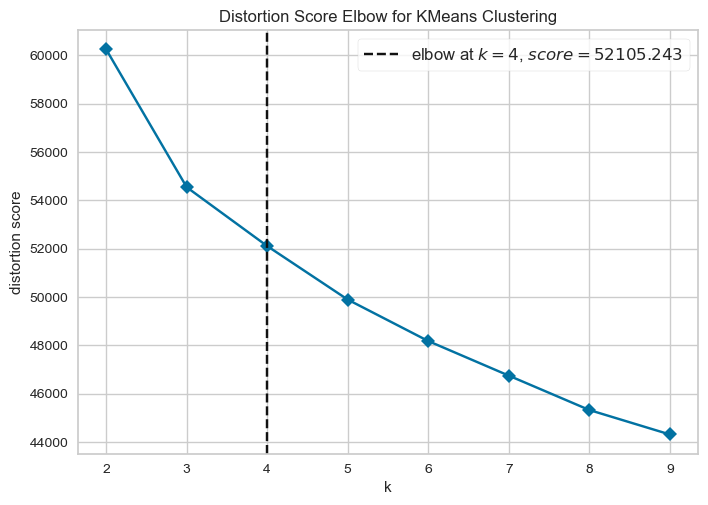

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
# Determine the Optimal Number of Clusters using the Elbow Method
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(2, 10), timings=False, n_init = 10)
visualizer.fit(X_standardized)
visualizer.show()

In [26]:
# Based on the Elbow Method, choose the optimal number of clusters
optimal_clusters = visualizer.elbow_value_

# Perform K-Means Clustering with the Optimal Number of Clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
final_df['Cluster'] = kmeans.fit_predict(X_standardized)
final_df

,CustomerID,TotalSales,Qty,UniqueSKU,NoInvoice,TotalNoDaysBilled,MaxValuedInvoice,2010-12,2011-01,2011-02,...,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,Cluster
0,17850,5391.21,1733,21,34,1,532.01,5391.21,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
1,13047,3237.54,1391,106,10,1,562.40,366.63,0.00,458.90,...,0.00,419.00,562.40,0.00,447.93,0.00,550.58,4.95,0.00,1
2,12583,7281.38,5060,115,15,1,855.86,855.86,730.16,321.56,...,0.00,421.96,617.48,329.24,243.10,868.03,314.20,1172.17,694.77,1
3,13748,948.25,439,24,5,1,335.80,204.00,0.00,0.00,...,376.85,0.00,0.00,0.00,0.00,367.40,0.00,0.00,0.00,2
4,15100,876.00,80,1,3,1,350.40,700.80,175.20,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4334,13436,196.89,76,12,1,1,196.89,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,196.89,3
4335,15520,343.50,314,18,1,1,343.50,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,343.50,2
4336,13298,360.00,96,2,1,1,360.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,360.00,3
4337,14569,227.39,79,10,1,1,227.39,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,227.39,3


In [27]:
# Analyze Clusters
cluster_analysis = final_df.groupby('Cluster').mean()
cluster_analysis

,CustomerID,TotalSales,Qty,UniqueSKU,NoInvoice,TotalNoDaysBilled,MaxValuedInvoice,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
Cluster,,,,,,,,,,,,,,,,,,,,
0,15215.709091,2564.710660,1513.265801,97.228571,5.467532,1.0,1007.139802,120.088424,194.754537,97.728857,152.649506,153.255222,185.090398,158.056242,163.437923,174.250216,258.665126,310.691022,356.636823,239.406364
1,15229.532663,11341.061658,6493.711055,181.278894,18.831658,1.0,1552.215075,850.832312,690.076583,650.655427,812.675075,553.206583,936.505000,914.577940,835.955126,911.064623,1206.046784,1203.986960,1301.371910,474.107337
2,15231.162647,728.274472,428.402597,40.991960,2.014224,1.0,521.837304,42.727396,32.947879,37.880804,43.109932,32.606024,45.745764,60.129932,39.826982,41.864014,96.213229,105.049035,122.112028,28.061453
3,15502.256630,199.833807,120.479042,13.746792,1.256630,1.0,180.228503,20.600120,13.075210,11.031391,21.131451,15.849262,14.332060,13.956197,11.228953,10.724644,14.033107,23.622197,24.766961,5.670386


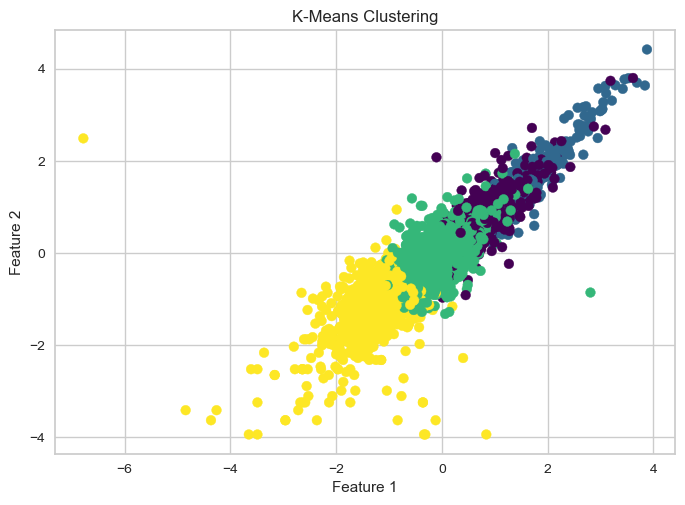

In [28]:
# Plot the clusters
plt.scatter(X_standardized[:, 0], X_standardized[:, 1], c=final_df['Cluster'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()